In [1]:
import pandas as pd
import os
import datetime
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Load database and format

In [2]:
clearance_df = pd.read_excel('AI_CAD_Database.xlsx', sheet_name='Database')

In [3]:
cad_map = {
    'MYN': 'CADe',
    'OEB': 'CADe',
    'PIB': 'CADa',
    'POK': 'CADx',
    'QAS': 'CADt',
    'QBS': 'CADe/x',
    'QDQ': 'CADe/x',
    'QFM': 'CADt',
    'QNP': 'CADe',
    'QPN': 'CADe/x'
}

clearance_df['CAD Type'] = clearance_df['Product Code'].map(cad_map)

In [4]:
clearance_df['Approval Year'] = [str(v)[:4] for v in clearance_df['Approval Date'].values]

In [5]:
# get unique products
product_df = clearance_df[pd.isnull(clearance_df['Current Number'])].copy()

# Set up plotting

In [6]:
sns.set_theme()
sns.set_style("ticks")

cad_order = ['CADt', 'CADe', 'CADx', 'CADe/x', 'CADa']

color_map = {}
for i, c in enumerate(cad_order):
    color_map[c] = sns.color_palette()[i]

cad_color_order = [color_map[c] for c in cad_order]

In [7]:
def create_split_count_df(orig_df, factor):
    data = []
    for idx, row in orig_df.iterrows():
        these_mods = np.unique(row[factor].split('|'))
        for m in these_mods:
            data.append([m, row['CAD Type']])

    split_df = pd.DataFrame(data, columns=[factor, 'CAD Type'])
    return split_df

# Basic counts

In [8]:
print('# of clearances', len(clearance_df))

# of clearances 140


In [9]:
print('# of products', len(product_df))

# of products 104


# CAD type counts

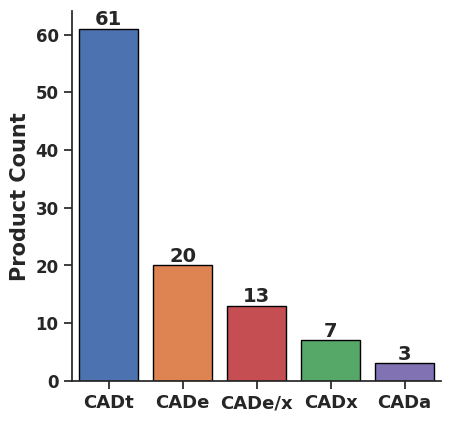

In [10]:
counts = product_df['CAD Type'].value_counts().reset_index()
counts.columns = ['CAD Type', 'Count']
sorted_counts = counts.sort_values(by='Count', ascending=False)

ax = sns.barplot(x='CAD Type', y='Count', data=sorted_counts, edgecolor='black')

plt.xticks(rotation=0, fontweight='bold', size=13)
plt.yticks(fontweight='bold', size=12)
sns.despine(top=True, right=True)

ax.set_ylabel('Product Count', fontweight='bold', size=15)
ax.set_xlabel('')
plt.title('')

colors = np.array([color_map[v] for v in sorted_counts['CAD Type'].values])
bars = ax.patches
for i, bar in enumerate(bars):
    bar.set_facecolor(colors[i]) 

for p in ax.patches:
    height = int(p.get_height())
    ax.annotate(f'{height}', (p.get_x() + p.get_width() / 2., height), ha='center', 
                va='bottom', fontweight='bold', fontsize=14)

x_vals = ax.get_xlim()
y_vals = ax.get_ylim()
plt.gca().set_aspect((x_vals[1] - x_vals[0])/(y_vals[1] - y_vals[0]))

# Clearances per year

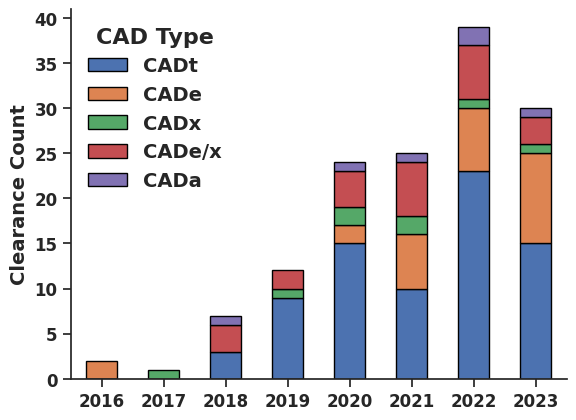

In [11]:
factor = 'Approval Year'
y_label = 'Clearance Count'

counts = clearance_df.groupby([factor, 'CAD Type']).size().reset_index(name='Count')

pivot_table = counts.pivot_table(index=factor, columns='CAD Type', values='Count', fill_value=0)
pivot_table = pivot_table[cad_order]

pivot_table['Total'] = pivot_table.sum(axis=1)
pivot_table.drop('Total', axis=1, inplace=True)

ax = pivot_table.plot(kind='bar', stacked=True, edgecolor='black', legend=False, color=cad_color_order) 
plt.xlabel('')
plt.ylabel(y_label, fontweight='bold', size=14)
plt.title('')

plt.xticks(rotation=0, fontweight='bold', ha='center', size=12)
plt.yticks(fontweight='bold', size=12)
sns.despine(top=True, right=True)

plt.legend(title='CAD Type', loc='best', prop={'weight':'bold', 'size': 14}, 
           frameon=False, title_fontproperties={'weight': 'bold', 'size': 16})

# Disease indications

In [12]:
factor = 'Disease/Condition'
plot_df = create_split_count_df(product_df, factor)

disease_counts = plot_df[factor].value_counts()
diseases_plot = disease_counts[disease_counts >= 3].index

plot_df = plot_df[plot_df[factor].isin(diseases_plot)]

plot_df.replace({'vertebral compression fracture': 'VCF', 'pulmonary embolism': 'PE'}, inplace=True)

d_map = {}
for d in plot_df[factor].values:
    if d.isupper():
        d_map[d] = d
    else:
        d_map[d] = d.title()
d_map['MSK fracture'] = 'MSK Fracture'

plot_df.replace(d_map, inplace=True)

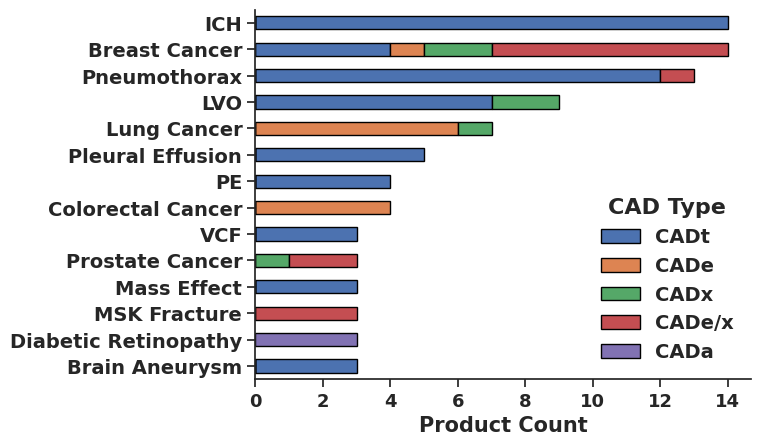

In [13]:
x_label = 'Product Count'

counts = plot_df.groupby([factor, 'CAD Type']).size().reset_index(name='Count')

pivot_table = counts.pivot_table(index=factor, columns='CAD Type', values='Count', fill_value=0)
pivot_table = pivot_table[cad_order]

pivot_table['Total'] = pivot_table.sum(axis=1)
pivot_table = pivot_table.sort_values(by='Total', ascending=True).drop('Total', axis=1)

ax = pivot_table.plot(kind='barh', stacked=True, edgecolor='black', legend=False, color=cad_color_order) 
plt.xlabel(x_label, fontweight='bold', size=15)
plt.ylabel('')
plt.title('')

plt.xticks(fontweight='bold', fontsize=13)
plt.yticks(fontweight='bold', size=14)
sns.despine(top=True, right=True)

plt.legend(title='CAD Type', loc='best', prop={'weight':'bold', 'size': 14}, 
           frameon=False, title_fontproperties={'weight': 'bold', 'size': 16})

# Prediction types

In [14]:
factor = 'Prediction Type'

plot_df = create_split_count_df(product_df, factor)
plot_df.replace({'categorical': 'category'}, inplace=True)
plot_df.replace({l: l.title() for l in plot_df[factor]}, inplace=True)

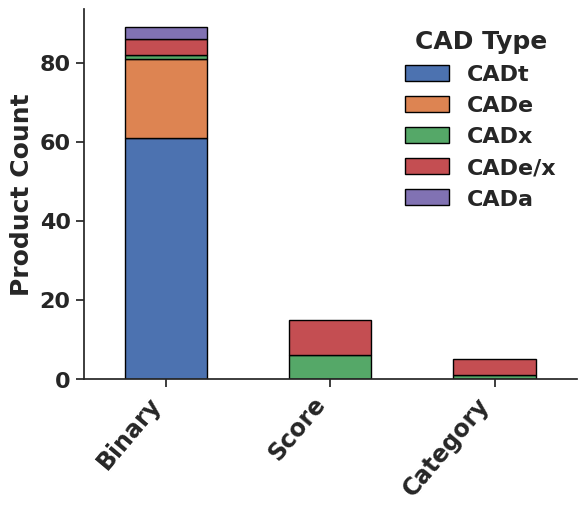

In [15]:
y_label = 'Product Count' 

counts = plot_df.groupby([factor, 'CAD Type']).size().reset_index(name='Count')

pivot_table = counts.pivot_table(index=factor, columns='CAD Type', values='Count', fill_value=0)
pivot_table = pivot_table[cad_order]

pivot_table['Total'] = pivot_table.sum(axis=1)
pivot_table = pivot_table.sort_values(by='Total', ascending=False).drop('Total', axis=1)

ax = pivot_table.plot(kind='bar', stacked=True, edgecolor='black', legend=False, color=cad_color_order) 
plt.xlabel('')
plt.ylabel(y_label, fontweight='bold', size=18)
plt.title('')

plt.xticks(rotation=50, fontweight='bold', ha='right', size=17)
plt.yticks(fontweight='bold', size=16)
sns.despine(top=True, right=True)

plt.legend(title='CAD Type', loc='upper right', prop={'weight':'bold', 'size': 16}, 
           frameon=False, title_fontproperties={'weight': 'bold', 'size': 18})

ax = plt.gca()
x_vals = ax.get_xlim()
y_vals = ax.get_ylim()
ax.set_aspect(0.75*(x_vals[1] - x_vals[0])/(y_vals[1] - y_vals[0]))

# Explainability types

In [16]:
factor = 'Explainability Type'

plot_df = create_split_count_df(product_df, factor)
plot_df.replace({l: l.title() for l in plot_df[factor]}, inplace=True)

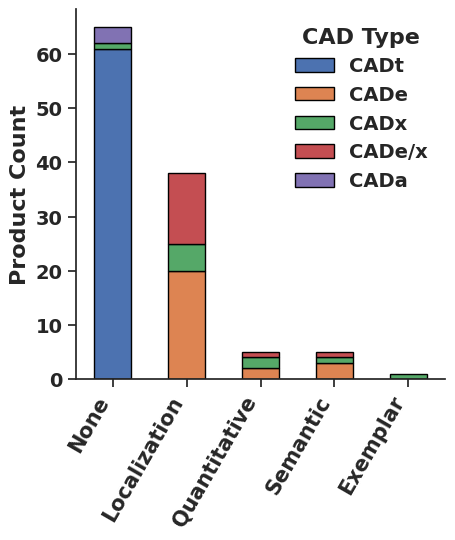

In [17]:
y_label = 'Product Count'

sns.set_theme()
sns.set_style("ticks")

counts = plot_df.groupby([factor, 'CAD Type']).size().reset_index(name='Count')

pivot_table = counts.pivot_table(index=factor, columns='CAD Type', values='Count', fill_value=0)
pivot_table = pivot_table[cad_order]

pivot_table['Total'] = pivot_table.sum(axis=1)
pivot_table = pivot_table.sort_values(by='Total', ascending=False).drop('Total', axis=1)

ax = pivot_table.plot(kind='bar', stacked=True, edgecolor='black', legend=False, color=cad_color_order) 
plt.xlabel('')
plt.ylabel(y_label, fontweight='bold', size=16)
plt.title('', fontweight='bold', size=20)

plt.xticks(rotation=60, fontweight='bold', ha='right', size=15)
plt.yticks(fontweight='bold', size=14)
sns.despine(top=True, right=True)

plt.legend(title='CAD Type', loc='upper right', prop={'weight':'bold', 'size': 14}, 
           frameon=False, title_fontproperties={'weight': 'bold', 'size': 16})

ax = plt.gca()
x_vals = ax.get_xlim()
y_vals = ax.get_ylim()
ax.set_aspect((x_vals[1] - x_vals[0])/(y_vals[1] - y_vals[0]))